This notebook is practice for how to use py4DSTEM to perform a multislice reconstruction of 4D STEM data, to get a handle on the API as well as to see how convergence goes with both infinite-dose and lower-dose (noisy) data. The practice datacube was generated using Dr. Probe and converted to py4DSTEM's native EMD format via a short python script.

In [4]:
import cupy.fft.config
import json
import py4DSTEM
import cupy as cp
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

# Helper functions for memory management, as demoed in the py4DSTEM tutorials
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()
fft_cache = cp.fft.config.get_plan_cache()

def release_class_gpu_memory(clear_fft_cache = True):
    if clear_fft_cache:
        fft_cache.clear()
    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()
    return None

fft_cache.set_size(0)

In [5]:
# It looks like the data isn't in quite the right format out of the box, so we'll go back to the JSON metadata to get everything set up
meta_path = "E:/Users/Sebastian/AlN/AlN_domain_walls/Cut/113_square_slides/AlN_DomainWall_4DSTEM/AlN_GaN_def_20nm.json"
with open(meta_path, "r") as metafile:
    meta = json.load(metafile)
pprint(meta)

{'averaged_diffraction': False,
 'averaged_tilt_precession': False,
 'beam_energy_ev': 200000.0,
 'data_dim': [1, 1440, 1440],
 'data_dim_names': ['thickness', 'k_y', 'k_x'],
 'data_type': 'float32',
 'diffraction': {'dim_names': ['k_y', 'k_x'],
                 'dims': [1440, 1440],
                 'num_qep_config': 1,
                 'offset': [720, 720],
                 'step': [0.133333, 0.133333],
                 'units': '1/nm'},
 'file_extension': '.dat',
 'file_folder': 'E:\\Users\\Sebastian\\AlN\\AlN_domain_walls\\Cut\\113_square_slides\\',
 'file_name': 'AlN_GaN_def_20nm',
 'name': 'E:\\Users\\Sebastian\\AlN\\AlN_domain_walls\\Cut\\113_square_slides\\AlN_GaN_def_20nm',
 'scan': {'dim_names': ['y', 'x'],
          'dims': [150, 150],
          'offset': [0, 0],
          'rotation': 0,
          'step': [0.05, 0.05],
          'units': 'nm'},
 'scanned_diffraction': True,
 'scanned_diffraction_files': 'E:\\Users\\Sebastian\\AlN\\AlN_domain_walls\\Cut\\113_square_slides\\Al

In [6]:
# Large files need to be read in as a memory map, since there is not enough space in RAM
# This always throws "RuntimeError: dictionary changed size during iteration" when first run
# If you just run the cell again it will work
datacube_path = "E:/Users/Sebastian/AlN/AlN_domain_walls/Cut/113_square_slides/AlN_DomainWall_4DSTEM/datacube_cropbin_more.emd"
uncalibrated = py4DSTEM.read(datacube_path)  # Raw data is an HDF5 object containing an Array, but is not a py4DSTEM-formatted DataCube

# We will set up a new Calibration object that we can attach to the data, using the meta info from the JSON file
calibration = py4DSTEM.Calibration()
calibration.set_R_pixel_units(meta["scan"]["units"])
calibration.set_R_pixel_size(meta["scan"]["step"][0]*2)  # Factor of two comes from the binning I did in pre-processing
calibration.set_Q_pixel_units("A^-1")  # Annoyingly py4DSTEM won't allow nm^-1 units, so we hardcode "A^-1" ...
calibration.set_Q_pixel_size(meta["diffraction"]["step"][0]*2/10)  # ... and manually convert nm^-1 to A^-1
datacube = py4DSTEM.DataCube(uncalibrated.data[25:125, 25:125, :, :], calibration=calibration)

pprint(datacube.calibration)  # Examine what fields exist in the new datacube

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.026666600000000002
             R_pixel_size:    0.1
             Q_pixel_units:   A^-1
             R_pixel_units:   nm
             QR_flip:         False
)


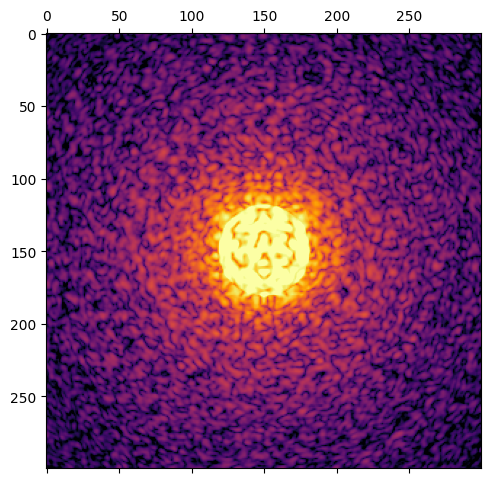

In [7]:
# Preview the mean diffraction pattern
py4DSTEM.show(datacube.data[75, 75, :, :], scaling="log", cmap="inferno")

100%|██████████| 10000/10000 [00:01<00:00, 9959.91it/s]


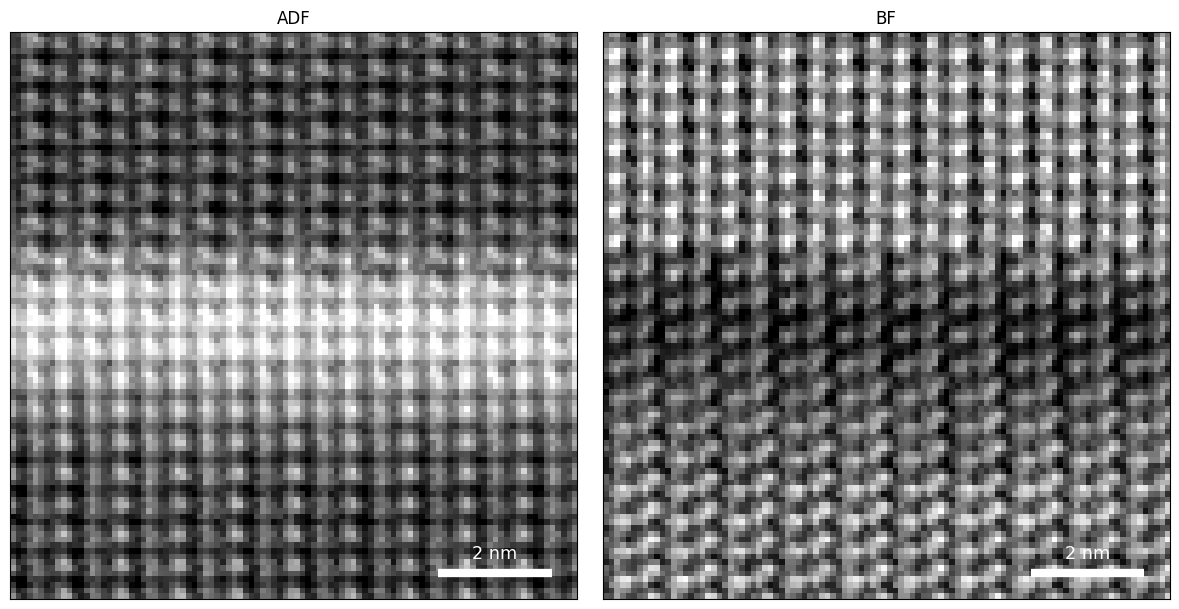

In [8]:
# We'll generate a virtual annular dark field image of the sample
_, probe_qx0, probe_qy0 = datacube.get_probe_size(datacube.data[75, 75, :, :])
datacube.get_virtual_image(mode='annulus', geometry=((probe_qx0, probe_qy0), (30, 200)), name='ADF')
# And the same, but a virtual bright field
datacube.get_virtual_image(mode='circle', geometry=((probe_qx0, probe_qy0), 21), name='BF')
py4DSTEM.show([datacube.tree("ADF"), datacube.tree('BF')], title=["ADF", "BF"], ticks=False)

Calculating center of mass: 100%|██████████| 10000/10000 [00:02<00:00, 3457.26probe position/s]
Best fit rotation forced to 0 degrees.
Normalizing amplitudes: 100%|██████████| 10000/10000 [00:04<00:00, 2437.85probe position/s]


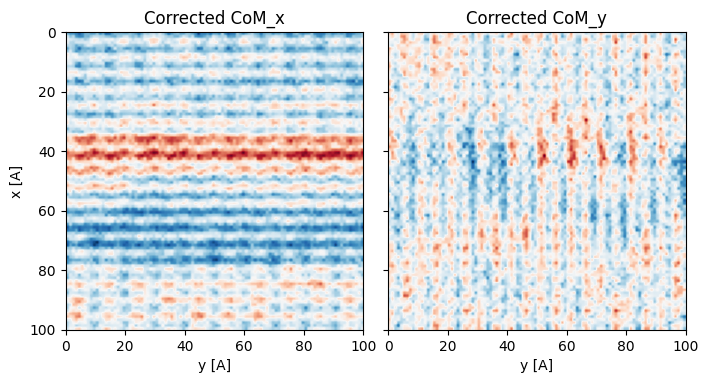

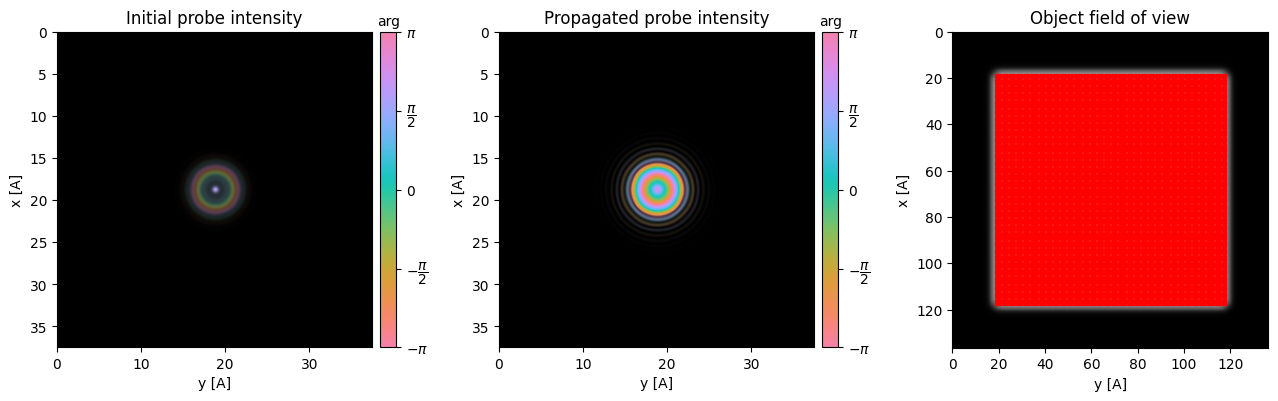

In [15]:
release_class_gpu_memory()

multislice = py4DSTEM.process.phase.MultislicePtychography(energy=200e3, datacube=datacube, slice_thicknesses=10, num_slices=12,
                                                           semiangle_cutoff=21, object_type="complex", defocus=200,
                                                           device="gpu", storage="cpu",
                                                           clear_fft_cache=False).preprocess(force_com_rotation=0, plot_rotation=False,
                                                                                             plot_probe_overlaps=True,
                                                                                             store_initial_arrays=False,
                                                                                             vectorized_com_calculation=False,
                                                                                             max_batch_size=512)

Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.5, in batches of max 32 measurements.
Reconstructing object and probe: 100%|██████████| 8/8 [1:41:07<00:00, 758.38s/ iter]


MultislicePtychography( A Node called 'multi-slice_ptychographic_reconstruction', containing the following top-level objects in its tree:

)

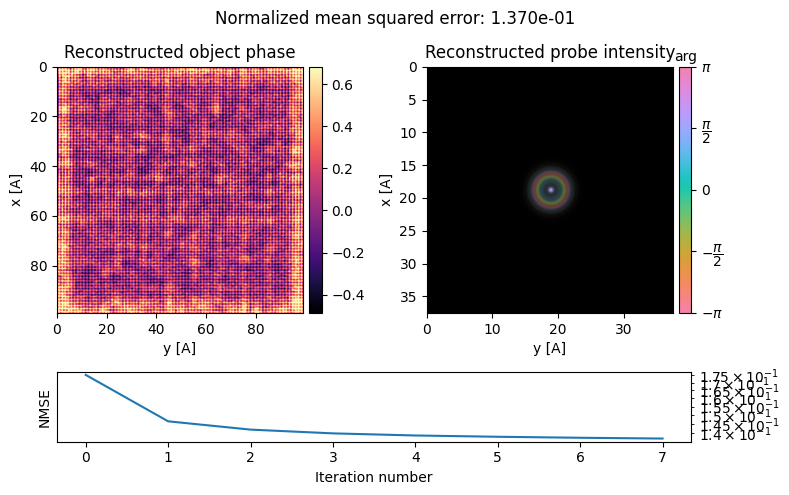

In [16]:
release_class_gpu_memory()
ptycho = multislice.reconstruct(max_batch_size=32, fix_positions=True, fix_probe=True,
                                object_positivity=True, store_iterations=False, q_lowpass=1)
ptycho.visualize()

In [17]:
# Plot it bigger, so we can see how good the reconstruction looks
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(np.sum(np.abs(ptycho.object)**2, axis=0), cmap="inferno")
ax.axis("off")
plt.tight_layout()
plt.show()